#MSTAR
This notebook shows how to load and view the [MSTAR data](https://www.sdms.afrl.af.mil/index.php?collection=mstar). The preprocessed data can be downloaded as below.

In [ ]:
import urllib.request
import numpy as np
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
urllib.request.urlretrieve('http://www-users.math.umn.edu/~jwcalder/SAR10.npz','SAR10.npz')
M = np.load('SAR10.npz', allow_pickle=True)
hdr,fields,mag,phase = M['hdr'],M['fields'],M['mag'],M['phase']

hdr contains the header information for each image, and fields is the titles of the columns.

In [ ]:
print('Header Shape:',hdr.shape)
print('Header fields:',fields)
print('Example header info:',hdr[0,:])

Header Shape: (6874, 7)
Header fields: ['TargetType' 'TargetSerNum' 'TargetAz' 'TargetRoll' 'TargetPitch'
 'TargetYaw' 'DesiredDepression']
Example header info: ['btr70_transport' 'c71' '27.006783' '-1.179039' '358.580475' '351.30838'
 '15']


mag contains all the magnitude images and phase all the phase images. The images are cropped to 88x88 pixels surrounding the object of interest in the center of the image.

In [ ]:
print(mag.shape)
print(phase.shape)

(6874, 88, 88)
(6874, 88, 88)


There are 10 target types, which are the labels for classification.

In [ ]:
np.unique(hdr[:,0])

array(['2s1_gun', 'bmp2_tank', 'brdm2_truck', 'btr60_transport',
       'btr70_transport', 'd7_bulldozer', 't62_tank', 't72_tank',
       'zil131_truck', 'zsu23-4_gun'], dtype=object)

The code below shows how to display some random images with their labels.

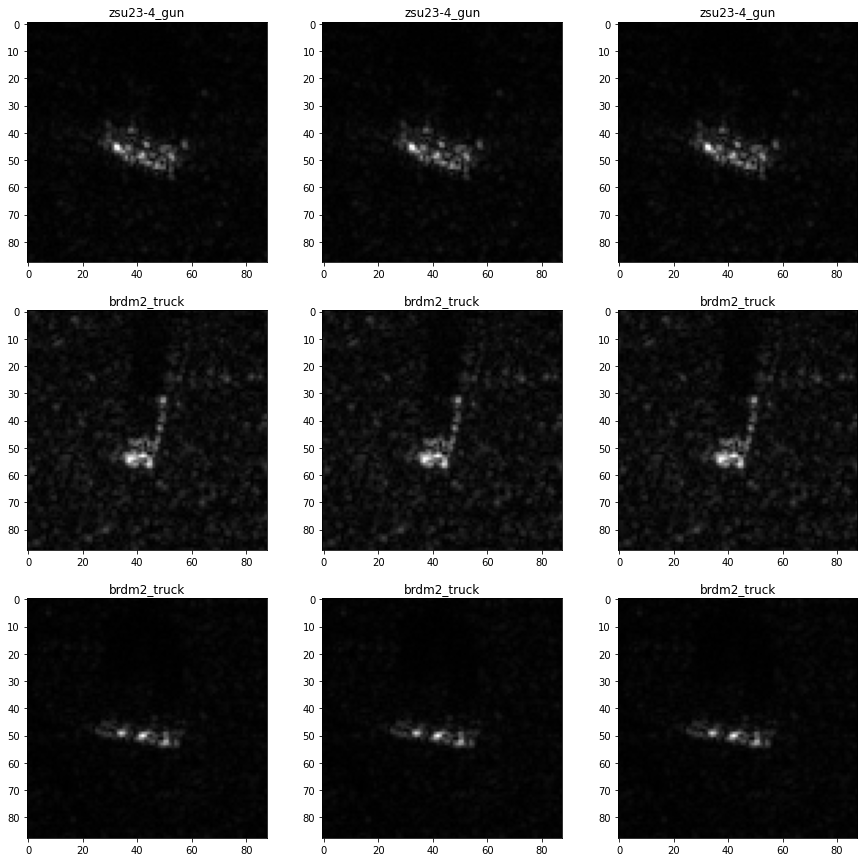

In [ ]:
import matplotlib.pyplot as plt

numx,numy = 3,3
fig, axs = plt.subplots(numx,numy,figsize=(15,15))
n = mag.shape[0]
R = np.random.permutation(n)
for i in range(numx):
    for j in range(numy):
        img = mag[R[i],:,:]
        #img = img/np.max(img)
        #img = np.log(img + 1e-3)
        axs[i,j].imshow(img,cmap='gray')
        axs[i,j].set_title(hdr[R[i],0])
        #axs[i,j].axis('off')

#Active learning methods
We explored the use of random sampling, Uncertainty Sampling, V-Optimality, $\sigma$-Optimality, Model Change, as well as MC-VOpt

In [ ]:
#Function to randomly select points from each class and perform laplace and poisson learning
def initial_run(W, labels, num_train_per_class, random_state, plot=False):
  #Initialize training points
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  np.random.seed(random_state)
  train_ind = gl.randomize_labels(labels,num_train_per_class)
  np.random.seed()
  print("%f%% training data"%(100*len(train_ind)/num_pts))

  #Laplace Learning
  u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
  labels_laplace = np.argmax(u_laplace, axis=1)
  laplace_acc = gl.accuracy(labels[test_idx], labels_laplace[test_idx], len(train_ind))

  #Poisson Learning
  u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
  labels_poisson = np.argmax(u_poisson, axis=1)
  poisson_acc = gl.accuracy(labels[test_idx], labels_laplace[test_idx], len(train_ind))

  #Output results
  # if plot is True: 
  #   scatterplot(data, labels, train_ind, []) 
  #   laplace_poisson(data, labels_laplace, labels_poisson)
  print('Number of Labels,Accuracy')
  print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
  print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

  return train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson

In [ ]:
#Function to perform simulation using random sampling
def random_simulation(W, labels, num_train_per_class, num_labels, random_state=0, plot=False):
  print("Random Sampling")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson = initial_run(W, labels, num_train_per_class, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  laplace = np.array([laplace_acc])
  poisson = np.array([poisson_acc])

  #loop for adding new labeled datapoints
  for i in range(num_labels-len(train_ind)):
    obj_values = np.ones(num_pts)
    obj_values[train_ind] = 0
    obj_values = obj_values/np.sum(obj_values)
    new_train_ind = np.random.choice(num_pts, size=1, replace=False, p=obj_values)
    train_ind = np.append(train_ind,new_train_ind)
    
    #Laplace Learning
    u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
    labels_laplace = np.argmax(u_laplace, axis=1)
    laplace_acc = gl.accuracy(labels[test_idx], labels_laplace[test_idx], len(train_ind))

    #Poisson Learning
    u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
    labels_poisson = np.argmax(u_poisson, axis=1)
    poisson_acc = gl.accuracy(labels[test_idx], labels_laplace[test_idx], len(train_ind))

    #Output results
    # if plot is True: 
    #   scatterplot(data, labels, train_ind, obj_values) 
    #   laplace_poisson(data, labels_laplace, labels_poisson) 
    print(obj_values.min(), obj_values.max())
    print('Number of Labels,Accuracy')
    print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
    print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    laplace = np.append(laplace, laplace_acc)
    poisson = np.append(poisson, poisson_acc)
  print()

  return num_train, laplace, poisson

In [ ]:
def stats(uncertainty_values, filename):
  mean = np.mean(uncertainty_values)
  std = np.std(uncertainty_values)
  quantile1 = np.quantile(uncertainty_values, 0.25)
  median = np.quantile(uncertainty_values, 0.5)
  quantile3 = np.quantile(uncertainty_values, 0.75)
  min = np.min(uncertainty_values)
  max = np.max(uncertainty_values)
  with open('%s.csv'%filename, 'a') as f:
    f.writelines(f"mean=%.3f, std=%.3f, quantiles=(%.3f, %.3f, %.3f, %.3f, %.3f)"%(mean,std,min,quantile1,median,quantile3,max)+'\n')

def uncertainty(u, labeled_ind=None):
    num_pts = u.shape[0]
    num_classes = u.shape[1]
    u_probs = softmax(u, axis=1) 
    one_hot_predicted_labels = np.eye(num_classes)[np.argmax(u, axis=1)]
    obj_values = np.linalg.norm((u_probs - one_hot_predicted_labels), axis=1)
    if labeled_ind is None:
        return obj_values
    else:
        obj_values[labeled_ind] = obj_values.min()
    return obj_values

#Function to perform simulation using uncertainty sampling
def uncertainty_simulation(W, labels, num_train_per_class, num_labels, random_state=0, plot=False):
  print("Uncertainty Sampling")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson = initial_run(W, labels, num_train_per_class, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  laplace = np.array([laplace_acc])
  poisson = np.array([poisson_acc])

  #loop for adding new labeled datapoints
  for i in range(num_labels-len(train_ind)):
    obj_values = uncertainty(u_laplace, train_ind)
    stats(obj_values, 'uncertainty_sampling')
    new_train_ind = np.argmax(obj_values)
    train_ind = np.append(train_ind,new_train_ind)
    
    #Laplace Learning
    u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
    labels_laplace = np.argmax(u_laplace, axis=1)
    laplace_acc = gl.accuracy(labels[test_idx], labels_laplace[test_idx], len(train_ind))

    #Poisson Learning
    u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
    labels_poisson = np.argmax(u_poisson, axis=1)
    poisson_acc = gl.accuracy(labels[test_idx], labels_laplace[test_idx], len(train_ind))

    #Output results
    if plot is True: 
      scatterplot(data, labels, train_ind, obj_values) 
      laplace_poisson(data, labels_laplace, labels_poisson) 
    print(obj_values.min(), obj_values.max())
    print('Number of Labels,Accuracy')
    print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
    print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    laplace = np.append(laplace, laplace_acc)
    poisson = np.append(poisson, poisson_acc)
  print()

  return num_train, laplace, poisson

In [ ]:
#Function to initialize covariance matrix
def init_c(evals, evecs, labeled_ind=None):
    # do not include evals that are very close to 0!
    K = (evecs/evals[np.newaxis, :]) @ evecs.T
    if labeled_ind is None:
      return K
    else:  
      unlabeled_ind = list(filter(lambda x: x not in labeled_ind, range(evecs.shape[0])))
      C = K[np.ix_(unlabeled_ind, unlabeled_ind)] - K[np.ix_(unlabeled_ind, labeled_ind)] @ linalg.inv(K[np.ix_(labeled_ind, labeled_ind)]) \
                                                              @ K[np.ix_(labeled_ind, unlabeled_ind)]
      print("negative diagonals:",np.sum(np.diag(C)<=0))
      print("negative entries:",np.sum(C<0))
      return C

#Function to update the covariance matrix
def update_c(C, max_idx, labeled_ind):
    unlabeled_ind = np.delete(np.arange(C.shape[0]+len(labeled_ind)), labeled_ind)
    k = np.where(unlabeled_ind == max_idx)[0][0]
    C -= np.outer(C[:,k], C[:,k])/C[k,k]
    not_k = np.delete(np.arange(C.shape[0]), k)
    C = C[np.ix_(not_k, not_k)]
    print("negative diagonals:",np.sum(np.diag(C)<=0))
    print("negative entries:",np.sum(C<0))
    return C

#Function to calculate v-opt objective function values
def v_opt(C, labeled_ind=None):
  unl_values = np.array([np.linalg.norm(C[i])**2/C[i,i] for i in range(C.shape[0])])
  if labeled_ind is None:
    return unl_values
  else:
    num_pts = C.shape[0] + len(labeled_ind)
    obj_values = np.ones(num_pts)*unl_values.min() 
    unlabeled_ind = np.delete(np.arange(num_pts), labeled_ind)
    obj_values[unlabeled_ind] = unl_values
    return obj_values

#Function to perform simulation using uncertainty sampling
def vopt_simulation(W, labels, num_train_per_class, num_labels, random_state=0, plot=False):
  print("V-Optimality")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson = initial_run(W, labels, num_train_per_class, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  laplace = np.array([laplace_acc])
  poisson = np.array([poisson_acc])

  #Formulations
  L=gl.graph_laplacian(W) #construct the graph laplacian
  k=int(.05*W.shape[0]) #number of eigenvalues/vectors
  vals, X = sparse.linalg.eigs(L,k=k, which='SM')
  X = X.real  
  vals = vals.real
  vals[0] = 0
  C = init_c(vals+1e-4, X, train_ind) #initialize cov matrix

  #loop for adding new labeled datapoints
  for i in range(num_labels-len(train_ind)):
    obj_values = v_opt(C, train_ind)
    new_train_ind = np.argmax(obj_values)
    C = update_c(C, new_train_ind, train_ind) #update cov matrix
    train_ind = np.append(train_ind,new_train_ind)
    
    #Laplace Learning
    u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
    labels_laplace = np.argmax(u_laplace, axis=1)
    laplace_acc = gl.accuracy(labels[test_idx], labels_laplace[test_idx], len(train_ind))

    #Poisson Learning
    u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
    labels_poisson = np.argmax(u_poisson, axis=1)
    poisson_acc = gl.accuracy(labels[test_idx], labels_laplace[test_idx], len(train_ind))

    #Output results
    # if plot is True: 
    #   scatterplot(data, labels, train_ind, obj_values) 
    #   laplace_poisson(data, labels_laplace, labels_poisson) 
    print(obj_values.min(), obj_values.max()) 
    print('Number of Labels,Accuracy')
    print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
    print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    laplace = np.append(laplace, laplace_acc)
    poisson = np.append(poisson, poisson_acc)
  print()

  return num_train, laplace, poisson

In [ ]:
#Function to calculate sigma-opt objective function values
def sigma_opt(C, labeled_ind=None):
  unl_values = np.array([np.sum(C[i])**2/C[i,i] for i in range(C.shape[0])])
  if labeled_ind is None:
    return unl_values
  else:
    num_pts = C.shape[0] + len(labeled_ind)
    obj_values = np.ones(num_pts)*unl_values.min() 
    unlabeled_ind = np.delete(np.arange(num_pts), labeled_ind)
    obj_values[unlabeled_ind] = unl_values
    return obj_values

#Function to perform simulation using uncertainty sampling
def sigmaopt_simulation(W, labels, num_train_per_class, num_labels, random_state=0, plot=False):
  print("Sigma-Optimality")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson = initial_run(W, labels, num_train_per_class, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  laplace = np.array([laplace_acc])
  poisson = np.array([poisson_acc])

  #Formulations
  L=gl.graph_laplacian(W) #construct the graph laplacian
  k=int(.05*W.shape[0]) #number of eigenvalues/vectors
  vals, X = sparse.linalg.eigs(L,k=k, which='SM')
  X = X.real  
  vals = vals.real
  vals[0] = 0
  C = init_c(vals+1e-4, X, train_ind) #initialize cov matrix

  #loop for adding new labeled datapoints
  for i in range(num_labels-len(train_ind)):
    obj_values = sigma_opt(C, train_ind) 
    new_train_ind = np.argmax(obj_values)
    C = update_c(C, new_train_ind, train_ind) #update cov matrix
    train_ind = np.append(train_ind,new_train_ind)
    
    #Laplace Learning
    u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
    labels_laplace = np.argmax(u_laplace, axis=1)
    laplace_acc = gl.accuracy(labels[test_idx], labels_laplace[test_idx], len(train_ind))

    #Poisson Learning
    u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
    labels_poisson = np.argmax(u_poisson, axis=1)
    poisson_acc = gl.accuracy(labels[test_idx], labels_laplace[test_idx], len(train_ind))

    #Output results
    # if plot is True: 
    #   scatterplot(data, labels, train_ind, obj_values) 
    #   laplace_poisson(data, labels_laplace, labels_poisson)
    print(obj_values.min(), obj_values.max()) 
    print('Number of Labels,Accuracy')
    print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
    print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    laplace = np.append(laplace, laplace_acc)
    poisson = np.append(poisson, poisson_acc)
  print()

  return num_train, laplace, poisson

In [ ]:
#Function to calculate MC-VOpt objective function values
def mc_vopt(C, u, labeled_ind=[]):
  num_pts = C.shape[0] + len(labeled_ind)
  unlabeled_ind = np.delete(np.arange(num_pts), labeled_ind)
  uncertainty_terms = uncertainty(u)[unlabeled_ind]
  unl_values = np.array([np.linalg.norm(C[i])**2/C[i,i] for i in range(C.shape[0])])*uncertainty_terms
  if labeled_ind is []:
    return unl_values, uncertainty_terms
  else:
    obj_values = np.ones(num_pts)*unl_values.min() 
    obj_values[unlabeled_ind] = unl_values
    return obj_values, uncertainty_terms

#Function to perform simulation using uncertainty sampling
def mc_vopt_simulation(W, labels, num_train_per_class, num_labels, random_state=0, plot=False):
  print("MC-VOptimality")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson = initial_run(W, labels, num_train_per_class, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  laplace = np.array([laplace_acc])
  poisson = np.array([poisson_acc])

  #Formulations
  L=gl.graph_laplacian(W) #construct the graph laplacian
  k=int(.05*W.shape[0]) #number of eigenvalues/vectors
  vals, X = sparse.linalg.eigs(L,k=k, which='SM')
  X = X.real  
  vals = vals.real
  vals[0] = 0
  C = init_c(vals+1e-4, X, train_ind) #initialize cov matrix

  #loop for adding new labeled datapoints
  for i in range(num_labels-len(train_ind)):
    obj_values, unc_values = mc_vopt(C, u_laplace, train_ind)
    stats(unc_values, 'mc_vopt') 
    new_train_ind = np.argmax(obj_values)
    C = update_c(C, new_train_ind, train_ind) #update cov matrix
    train_ind = np.append(train_ind,new_train_ind)
    
    #Laplace Learning
    u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
    labels_laplace = np.argmax(u_laplace, axis=1)
    laplace_acc = gl.accuracy(labels[test_idx], labels_laplace[test_idx], len(train_ind))

    #Poisson Learning
    u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
    labels_poisson = np.argmax(u_poisson, axis=1)
    poisson_acc = gl.accuracy(labels[test_idx], labels_laplace[test_idx], len(train_ind))

    #Output results
    if plot is True: 
      scatterplot(data, labels, train_ind, obj_values) 
      laplace_poisson(data, labels_laplace, labels_poisson) 
    print(obj_values.min(), obj_values.max())
    print('Number of Labels,Accuracy')
    print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
    print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    laplace = np.append(laplace, laplace_acc)
    poisson = np.append(poisson, poisson_acc)
  print()

  return num_train, laplace, poisson

In [ ]:
#Function to calculate MC-VOpt objective function values
def model_change(C, u, labeled_ind=[]):
  num_pts = C.shape[0] + len(labeled_ind)
  unlabeled_ind = np.delete(np.arange(num_pts), labeled_ind)
  uncertainty_terms = uncertainty(u)[unlabeled_ind]
  unl_values = np.array([np.linalg.norm(C[i])/C[i,i] for i in range(C.shape[0])])*uncertainty_terms
  if labeled_ind is []:
    return unl_values, uncertainty_terms
  else:
    obj_values = np.ones(num_pts)*unl_values.min() 
    obj_values[unlabeled_ind] = unl_values
    return obj_values, uncertainty_terms

#Function to perform simulation using uncertainty sampling
def mc_simulation(W, labels, num_train_per_class, num_labels, random_state=0, plot=False):
  print("MC-Laplace")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson = initial_run(W, labels, num_train_per_class, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  laplace = np.array([laplace_acc])
  poisson = np.array([poisson_acc])

  #Formulations
  L=gl.graph_laplacian(W) #construct the graph laplacian
  k=int(.05*W.shape[0]) #number of eigenvalues/vectors
  vals, X = sparse.linalg.eigs(L,k=k, which='SM')
  X = X.real  
  vals = vals.real
  vals[0] = 0
  C = init_c(vals+1e-4, X, train_ind) #initialize cov matrix

  #loop for adding new labeled datapoints
  for i in range(num_labels-len(train_ind)):
    obj_values, unc_values = model_change(C, u_laplace, train_ind) 
    stats(unc_values, 'mc_laplace')
    new_train_ind = np.argmax(obj_values)
    C = update_c(C, new_train_ind, train_ind) #update cov matrix
    train_ind = np.append(train_ind,new_train_ind)
    
    #Laplace Learning
    u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
    labels_laplace = np.argmax(u_laplace, axis=1)
    laplace_acc = gl.accuracy(labels[test_idx], labels_laplace[test_idx], len(train_ind))

    #Poisson Learning
    u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
    labels_poisson = np.argmax(u_poisson, axis=1)
    poisson_acc = gl.accuracy(labels[test_idx], labels_laplace[test_idx], len(train_ind))

    #Output results
    if plot is True: 
      scatterplot(data, labels, train_ind, obj_values) 
      laplace_poisson(data, labels_laplace, labels_poisson) 
    print(obj_values.min(), obj_values.max())
    print('Number of Labels,Accuracy')
    print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
    print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    laplace = np.append(laplace, laplace_acc)
    poisson = np.append(poisson, poisson_acc)
  print()

  return num_train, laplace, poisson

In [ ]:
#Function to plot the laplace and poisson accuracy
def lineplot(num_train, random_acc, uncertainty_acc, vopt_acc, sopt_acc, mc_acc, mcvopt_acc, method, filename=None):
  plt.figure(figsize=(12, 8), dpi=100)
  matplotlib.rcParams.update({'font.size': 16})
  plt.plot(num_train, random_acc, 'gx-', markersize=10, label='Random')
  plt.plot(num_train, uncertainty_acc, 'c+-', markersize=10, label='Uncertainty')
  plt.plot(num_train, vopt_acc, 'bv-', markersize=10, label='V-Opt')
  plt.plot(num_train, sopt_acc, 'rs-', markersize=10, label='Sigma-Opt')
  # plt.plot(num_train, mc_acc, 'mo-', markersize=10, label='Model Change')
  plt.plot(num_train, mcvopt_acc, 'k*-', markersize=10, label='MC-VOpt')
  plt.plot(num_train, np.ones(len(num_train))*83.55, 'g--', label='CNN')
  plt.xlabel('number of labeled points')
  plt.ylabel('%s Learning Accuracy'%method)
  plt.legend()
  if filename is not None: plt.savefig('%s.png'%filename)
  plt.show()
  print("rand: %.3f"%random_acc.max(), "unc: %.3f"%uncertainty_acc.max(), "vopt: %.3f"%vopt_acc.max(), "sopt: %.3f"%sopt_acc.max(), "mc: %.3f"%mc_acc.max(), "mc-vopt: %.3f"%mcvopt_acc.max())

#CNN Classifier
Here we explore a simple convolutional neural network for classification. We first define the network and train/test functions.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import datasets
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from scipy.special import softmax
import sys
import os

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        w = (32,64) #Number of channels in 1st and 2nd layers
        self.conv1 = nn.Conv2d(1, w[0], 3, 1)
        self.conv2 = nn.Conv2d(w[0], w[1], 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        f = 512  #Number of hidden nodes in fully connected layers
        self.fc1 = nn.Linear(w[1]*10*10, f)
        self.fc2 = nn.Linear(f, 10)
        self.bn1 = nn.BatchNorm1d(f)

    def forward(self, x): #88
        x = self.conv1(x) #86 
        x = F.relu(x)
        x = F.max_pool2d(x, 2) #43
        x = self.conv2(x) #41
        x = F.relu(x)
        x = F.max_pool2d(x, 4)  #10
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn1(x)   #batch normalization
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

    #This is useful for extracting features from convolutional part of NN
    def convnet(self, x):
        x = self.conv1(x) #86 
        x = F.relu(x)
        x = F.max_pool2d(x, 2) #43
        x = self.conv2(x) #41
        x = F.relu(x)
        x = F.max_pool2d(x, 4)  #10
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        return x

def train(model, device, data_train, target_train, optimizer, epoch, batch_size):
    model.train()
    batch_idx = 0
    for idx in range(0,len(data_train),batch_size):
        data, target = data_train[idx:idx+batch_size], target_train[idx:idx+batch_size]
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == -1:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(target_train),
                100. * batch_idx / int(len(data_train)/batch_size), loss.item()))
        batch_idx += 1


def test(model, device, data_test, target_test,name):
    batch_size = 1000
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for idx in range(0,len(data_test),batch_size):
            data, target = data_test[idx:idx+batch_size], target_test[idx:idx+batch_size]
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(target_test)

    print(name+' set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(target_test),
        100. * correct / len(target_test)))

We now preprocess the data: convert labels to integers, train/test split, converting to Torch, randomly shuffling traiing set.

In [ ]:
#Convert targets to numerical labels
target = hdr[:,0].tolist()
classes = set(target)
label_dict = dict(zip(classes, np.arange(len(classes))))
labels = np.array([label_dict[t] for t in target],dtype=int)

#Training and testing split (based on papers)
angle = hdr[:,6].astype(int)
train_idx = angle == 17
test_idx = angle == 15

#reducing training size
all_indexes = np.arange(hdr.shape[0])
train_indexes_used = all_indexes[train_idx]
test_data_indexes = all_indexes[test_idx]
smaller_train_idx = np.random.choice(train_indexes_used, int(hdr.shape[0]*.075), replace=False)  

#Train testing split and convert to torch
data = torch.from_numpy(np.reshape(mag,(mag.shape[0],1,mag.shape[1],mag.shape[2]))).float()
labels = torch.from_numpy(labels).long()
data_train = data[smaller_train_idx,:,:,:]
data_test = data[test_idx,:,:,:]
target_train = labels[smaller_train_idx]
target_test = labels[test_idx]

#Randomly shuffle training data
P = torch.randperm(len(smaller_train_idx))
data_train = data_train[P,:,:,:]
target_train = target_train[P]

Now we train the convolutional neural network.

In [ ]:
#Training settings
cuda = True   #Use GPU acceleration (Edit->Notebook Settings and enable GPU)
batch_size = 150
learning_rate = 1    #Learning rate
gamma = 0.9     #Learning rate step
epochs = 50

#Cuda and optimizer/scheduler
use_cuda = cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

#Main training loop
for epoch in range(1, epochs + 1):
    train(model, device, data_train, target_train, optimizer, epoch, batch_size)
    print('\nEpoch: %d'%epoch)
    test(model, device, data_test, target_test, 'Test ')
    test(model, device, data_train, target_train, 'Train')
    scheduler.step()

#Save model
torch.save(model.state_dict(), 'SAR10_cnn.pt')

#Save encoded data
model.eval()
with torch.no_grad():
    Y = model.convnet(data.to(device)).cpu().numpy()  
    np.savez_compressed('SAR10_cnn.npz',data=Y,labels=labels.numpy())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Epoch: 1
Test  set: Average loss: 2.2683, Accuracy: 402/3203 (12.55%)
Train set: Average loss: 2.2329, Accuracy: 86/515 (16.70%)

Epoch: 2
Test  set: Average loss: 2.1712, Accuracy: 460/3203 (14.36%)
Train set: Average loss: 2.1257, Accuracy: 100/515 (19.42%)

Epoch: 3
Test  set: Average loss: 2.0631, Accuracy: 1601/3203 (49.98%)
Train set: Average loss: 1.9842, Accuracy: 341/515 (66.21%)

Epoch: 4
Test  set: Average loss: 1.9889, Accuracy: 1660/3203 (51.83%)
Train set: Average loss: 1.8948, Accuracy: 351/515 (68.16%)

Epoch: 5
Test  set: Average loss: 1.9504, Accuracy: 1363/3203 (42.55%)
Train set: Average loss: 1.8339, Accuracy: 306/515 (59.42%)

Epoch: 6
Test  set: Average loss: 1.8981, Accuracy: 1533/3203 (47.86%)
Train set: Average loss: 1.7617, Accuracy: 309/515 (60.00%)

Epoch: 7
Test  set: Average loss: 1.8254, Accuracy: 1563/3203 (48.80%)
Train set: Average loss: 1.6632, Accuracy: 306/515 (59.42%)

Epoch: 8
Test  set: Average loss: 1.7105, Accuracy: 1690/3203 (52.76%)
Train s

#Active learning on CNN Output
As a simple first step, we can apply graph-based active learning to the CNN encoded features.

In [ ]:
pip install -q graphlearning

     |████████████████████████████████| 49 kB 3.8 MB/s 
     |████████████████████████████████| 646 kB 13.0 MB/s 
     |████████████████████████████████| 93 kB 1.7 MB/s 


In [ ]:
## Import useful packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import graphlearning as gl
from scipy import sparse, linalg
from scipy.special import softmax
import urllib.request

In [ ]:
## Function to generate the weight matrix
def weight_matrix(data):
  boolean = False
  k=1
  I,J,D = gl.knnsearch_annoy(data, 50, similarity='angular')
  D[D==0] = 1e-150

  while boolean==False:
    k+=1
    W = gl.weight_matrix(I,J,D,k)
    boolean = gl.isconnected(W)
    print("k=%d"%k, "connected=%s"%boolean)

  k=2*k
  W = gl.weight_matrix(I,J,D,k)
  print("k=%d"%k, "connected=%s"%boolean)
  print("weight matrix shape: ", W.shape)
  
  return W

In [ ]:
M = np.load('SAR10_cnn.npz')
X = M['data']   #Encoded data
labels = M['labels'] #Labels

print(X.shape)
print(labels.shape)
print(X)
print(labels)

(6874, 6400)
(6874,)
[[0.         0.         0.         ... 0.0016148  0.00921941 0.00765862]
 [0.00390006 0.01068236 0.0128602  ... 0.         0.00077016 0.        ]
 [0.00067341 0.00059865 0.         ... 0.         0.00258572 0.        ]
 ...
 [0.02483121 0.0170596  0.02174529 ... 0.         0.         0.00323747]
 [0.01366705 0.02712159 0.01066928 ... 0.         0.         0.00122217]
 [0.0078749  0.02512947 0.02968277 ... 0.         0.         0.        ]]
[4 4 4 ... 8 8 8]


In [ ]:
#1. Raw CNN Output
W = weight_matrix(X)
_, mc_vopt_laplace, mc_vopt_poisson = mc_vopt_simulation(W, labels, 10, 200)
_, vopt_laplace, vopt_poisson = vopt_simulation(W, labels, 10, 200)
num_train, random_laplace, random_poisson = random_simulation(W, labels, 10, 200)
_, unc_laplace, unc_poisson = uncertainty_simulation(W, labels, 10, 200)
_, sopt_laplace, sopt_poisson = sigmaopt_simulation(W, labels, 10, 200)

MC-VOptimality
1.454757% training data
Number of Labels,Accuracy
Laplace: 100,73.348
Poisson: 100,73.348
negative diagonals: 0
negative entries: 17246576
negative diagonals: 0
negative entries: 17732094
5.4306395149969235 96.66373341923794
Number of Labels,Accuracy
Laplace: 101,74.178
Poisson: 101,74.178
negative diagonals: 0
negative entries: 18259132
5.431250541639521 90.99997364835205
Number of Labels,Accuracy
Laplace: 102,76.427
Poisson: 102,76.427
negative diagonals: 0
negative entries: 18922056
5.43179160653007 83.57782325290687
Number of Labels,Accuracy
Laplace: 103,79.323
Poisson: 103,79.323
negative diagonals: 0
negative entries: 19156658
5.432023943360138 59.618751335992364
Number of Labels,Accuracy
Laplace: 104,80.284
Poisson: 104,80.284
negative diagonals: 0
negative entries: 19294462
5.431112759405568 56.00457198365661
Number of Labels,Accuracy
Laplace: 105,81.601
Poisson: 105,81.601
negative diagonals: 0
negative entries: 19470054
5.431901091043067 50.93673939718617
Numbe

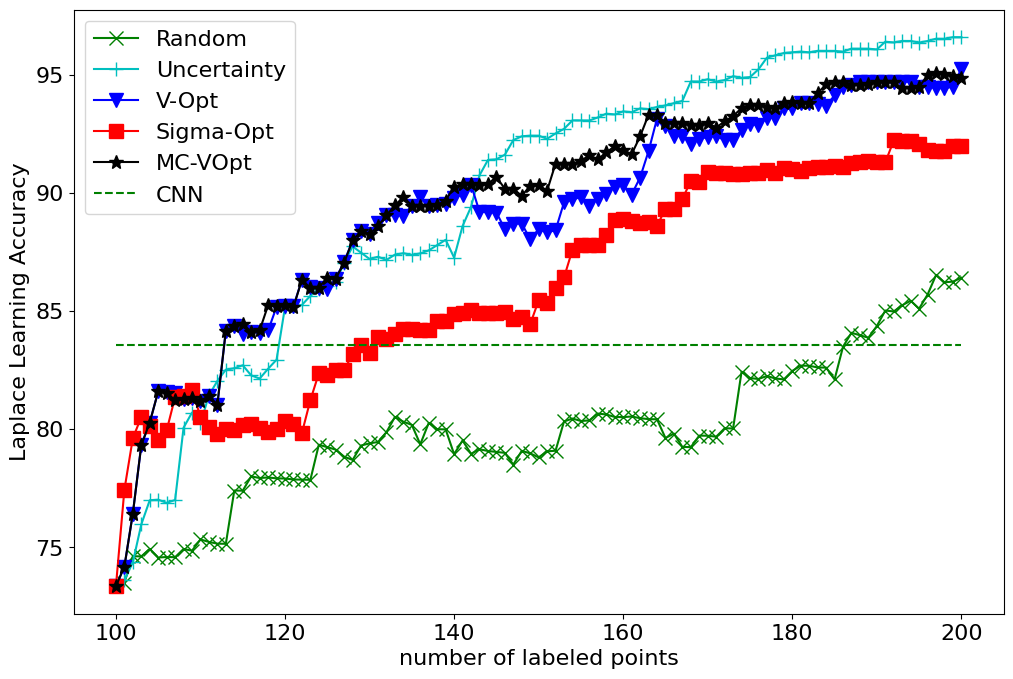

rand: 86.527 unc: 96.605 vopt: 95.271 sopt: 92.228 mc: 200.000 mc-vopt: 95.077


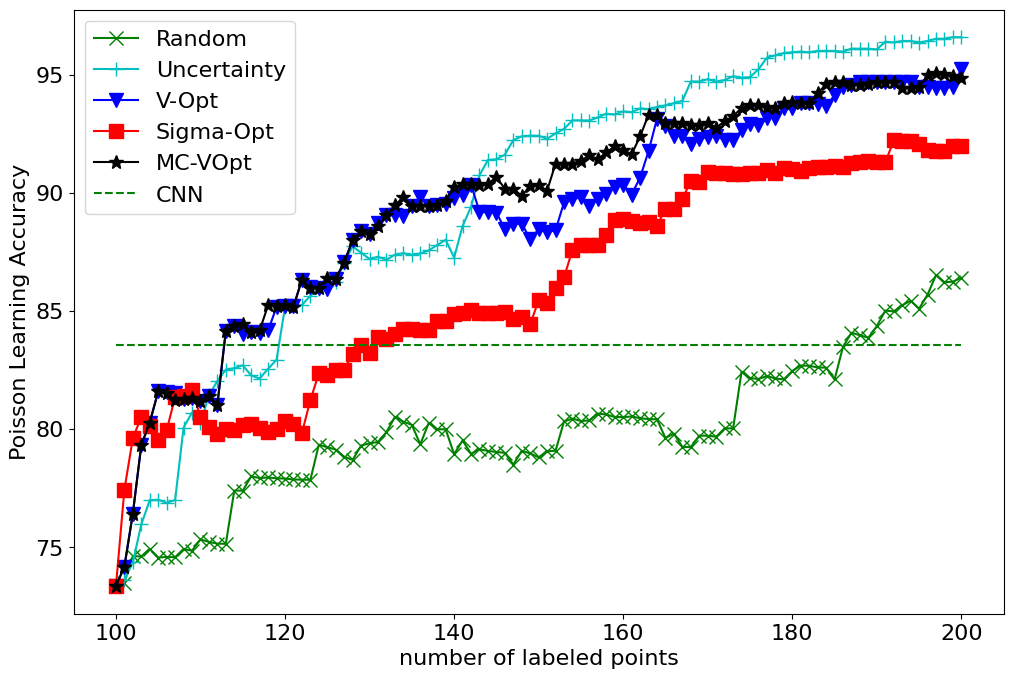

rand: 86.527 unc: 96.605 vopt: 95.271 sopt: 92.228 mc: 200.000 mc-vopt: 95.077


In [ ]:
lineplot(num_train, random_laplace, unc_laplace, vopt_laplace, sopt_laplace, _, mc_vopt_laplace, 'Laplace', filename='Raw_Laplace')
lineplot(num_train, random_poisson, unc_poisson, vopt_poisson, sopt_poisson, _, mc_vopt_poisson, 'Poisson', filename='Raw_Poisson')

# CNN VAE

In [ ]:
import imageio
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import torchvision.transforms as transforms

to_pil_image = transforms.ToPILImage()

def image_to_vid(images):
    imgs = [np.array(to_pil_image(img)) for img in images]
    imageio.mimsave('generated_images.gif', imgs)

def save_reconstructed_images(recon_images, epoch):
    save_image(recon_images.cpu(), f"output{epoch}.jpg")

def save_loss_plot(train_loss, valid_loss):
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(valid_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss.jpg')
    plt.show()

In [ ]:
# Imports
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import Dataset, DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
from torch.optim.lr_scheduler import StepLR
import matplotlib
from torchvision.utils import make_grid

matplotlib.style.use('ggplot')

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

# Loss function (POTENTIALLY CHANGE BCE TO NLL)
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training function
def train(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
        counter += 1
        data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()

    train_loss = running_loss / counter 
    return train_loss

# Validation function
def validate(model, dataloader, dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
            counter += 1
            data = data[0]
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(dataset)/dataloader.batch_size) - 1:
                recon_images = reconstruction

    val_loss = running_loss / counter
    return val_loss, recon_images

In [ ]:
kernel_size = 3 # (3, 3) kernel
num_classes = 10
init_channels = 8 # initial number of filters
image_channels = 1
latent_dim = 32 # latent dimension for sampling

# define a Conv VAE
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, 
            stride=1, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*3, kernel_size=kernel_size, 
            stride=1, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*3, out_channels=init_channels*6, kernel_size=kernel_size, 
            stride=1, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*6, out_channels=init_channels*10, kernel_size=kernel_size, 
            stride=2, padding=0
        )
        # fully connected layers for learning representations
        self.fc1 = nn.Linear((init_channels*10)*10*10, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_log_var = nn.Linear(256, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 128)
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=128, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=1, padding=0, output_padding=1, dilation=3
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=0, output_padding=1, dilation=3
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1, output_padding=1, dilation=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size, 
            stride=2, padding=1, output_padding=1, dilation=1
        )

        self.dropout1 = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm1d(32)

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x): #88
        # encoding
        x = F.relu(self.enc1(x)) #88
        x = F.adaptive_avg_pool2d(x, 44) #44
        x = F.relu(self.enc2(x)) #44
        x = F.adaptive_avg_pool2d(x, 22) #22
        x = F.relu(self.enc3(x)) #22
        x = F.relu(self.enc4(x)) #10
        batch, _, _, _ = x.shape
        x = x.reshape(batch, -1)
        hidden = self.fc1(x) 
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var) #(64, 32)
        z = self.dropout1(z)
        z = self.bn1(z)
        z = self.fc2(z) #(64, 64)
        z = z.view(-1, 128, 1, 1)
 
        # decoding
        x = F.relu(self.dec1(z)) #8
        x = F.relu(self.dec2(x)) #22
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var

    def encode(self, x):
        x = F.relu(self.enc1(x)) #88
        x = F.adaptive_avg_pool2d(x, 44) #44
        x = F.relu(self.enc2(x)) #44
        x = F.adaptive_avg_pool2d(x, 22) #22
        x = F.relu(self.enc3(x)) #22
        x = F.relu(self.enc4(x)) #10
        x = x.reshape(x.shape[0], -1)
        return x

In [ ]:
kernel_size = 3 # (3, 3) kernel
num_classes = 10
init_channels = 8 # initial number of filters
image_channels = 1
latent_dim = 32 # latent dimension for sampling

# define a Conv VAE
class XCVAE(nn.Module):
    def __init__(self):
        super(XCVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, 
            stride=1, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=1, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=1, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4, out_channels=64, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64*11*11, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=1, padding=0, output_padding=1, dilation=3
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=0, output_padding=1, dilation=3
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1, output_padding=1, dilation=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size, 
            stride=2, padding=1, output_padding=1, dilation=1
        )
        self.droupout1 = nn.Dropout(0.5)

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x): #88
        # encoding
        x = F.relu(self.enc1(x)) #88
        x = F.max_pool2d(x, 2) #44
        x = F.relu(self.enc2(x)) #44
        x = F.max_pool2d(x, 2) #22
        x = F.relu(self.enc3(x)) #22
        x = F.relu(self.enc4(x)) #11
        batch, _, _, _ = x.shape
        x = self.droupout1(x)
        x = x.reshape(batch, -1)
        hidden = self.fc1(x) #(64*11*11, 128)
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var) #(64, 16)
        z = self.fc2(z) #(64, 64)
        z = z.view(-1, 64, 1, 1)
 
        # decoding
        x = F.relu(self.dec1(z)) #8
        x = F.relu(self.dec2(x)) #22
        x = self.droupout1(x)
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var

    def encode(self, x):
        x = F.relu(self.enc1(x)) #88
        x = F.max_pool2d(x, 2) #44
        x = F.relu(self.enc2(x)) #44
        x = F.max_pool2d(x, 2) #22
        x = F.relu(self.enc3(x)) #22
        x = F.relu(self.enc4(x)) #11
        x = self.droupout1(x)
        x = x.reshape(x.shape[0], -1)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize the model
model = XCVAE().to(device)

# set the learning parameters
lr = 0.001
epochs = 50
batch_size = 64
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

cuda = True
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

# a list to save all the reconstructed images in PyTorch grid format
grid_images = []

In [ ]:
#Convert targets to numerical labels
target = hdr[:,0].tolist()
classes = set(target)
label_dict = dict(zip(classes, np.arange(len(classes))))
labels = np.array([label_dict[t] for t in target],dtype=int)

#Training and testing split (based on papers)
angle = hdr[:,6].astype(int)
train_idx = angle == 17
test_idx = angle == 15

#Train testing split and convert to torch
data = torch.from_numpy(np.reshape(mag,(mag.shape[0],1,mag.shape[1],mag.shape[2]))).float()
#data = data / torch.max(data)
labels = torch.from_numpy(labels).long()
data_train = data[train_idx,:,:,:]
data_test = data[test_idx,:,:,:]
target_train = labels[train_idx]
target_test = labels[test_idx]

# Creating indexes for later graph learning use
all_indexes = np.arange(data.shape[0])
train_indexes_used = all_indexes[train_idx]
test_data_indexes = all_indexes[test_idx]

#Randomly shuffle training data
P = torch.randperm(np.sum(train_idx))
data_train = data_train[P,:,:,:]
target_train = target_train[P]

#Convert to torch dataloaders
dTr = data_train
dV = data_test
tTr = target_train
tV = target_test

SAR_train = MyDataset(dTr, tTr) 
trainloader = DataLoader(SAR_train, batch_size = batch_size, shuffle = True, **kwargs)

SAR_validate = MyDataset(dV, tV) 
testloader = DataLoader(SAR_validate, batch_size = batch_size, shuffle = True, **kwargs)

Epoch 1 of 50


58it [00:01, 54.09it/s]                        
51it [00:00, 128.21it/s]                        


Train Loss: 278364.2982
Val Loss: 167220.7167
Epoch 2 of 50


58it [00:00, 61.52it/s]                        
51it [00:00, 127.30it/s]                        


Train Loss: 149096.4582
Val Loss: 123201.1003
Epoch 3 of 50


58it [00:00, 61.18it/s]                        
51it [00:00, 128.36it/s]                        


Train Loss: 120587.6683
Val Loss: 103250.4709
Epoch 4 of 50


58it [00:00, 61.32it/s]                        
51it [00:00, 129.01it/s]                        


Train Loss: 110535.0478
Val Loss: 99901.8746
Epoch 5 of 50


58it [00:00, 61.69it/s]                        
51it [00:00, 128.86it/s]                        


Train Loss: 108670.3128
Val Loss: 99076.8310
Epoch 6 of 50


58it [00:00, 61.73it/s]                        
51it [00:00, 123.72it/s]                        

Train Loss: 107975.1657
Val Loss: 98606.1327
Epoch 7 of 50



58it [00:00, 61.87it/s]                        
51it [00:00, 127.74it/s]                        


Train Loss: 107571.1820
Val Loss: 98279.0552
Epoch 8 of 50


58it [00:00, 59.79it/s]                        
51it [00:00, 122.56it/s]                        

Train Loss: 107284.5208
Val Loss: 98209.2586
Epoch 9 of 50



58it [00:00, 59.97it/s]                        
51it [00:00, 125.50it/s]                        

Train Loss: 107107.5671
Val Loss: 98019.1713
Epoch 10 of 50



58it [00:00, 60.87it/s]                        
51it [00:00, 125.20it/s]                        


Train Loss: 106915.0067
Val Loss: 97862.8405
Epoch 11 of 50


58it [00:00, 60.94it/s]                        
51it [00:00, 125.57it/s]                        


Train Loss: 106770.4128
Val Loss: 97784.7264
Epoch 12 of 50


58it [00:00, 60.85it/s]                        
51it [00:00, 124.96it/s]                        

Train Loss: 106613.2806
Val Loss: 97808.9483
Epoch 13 of 50



58it [00:00, 60.82it/s]                        
51it [00:00, 125.71it/s]                        

Train Loss: 106490.8671
Val Loss: 97581.9266
Epoch 14 of 50



58it [00:00, 60.49it/s]                        
51it [00:00, 124.54it/s]                        


Train Loss: 106360.7792
Val Loss: 97514.9983
Epoch 15 of 50


58it [00:00, 60.41it/s]                        
51it [00:00, 129.31it/s]                        


Train Loss: 106260.8679
Val Loss: 97403.2603
Epoch 16 of 50


58it [00:00, 61.18it/s]                        
51it [00:00, 121.15it/s]                        

Train Loss: 106157.5018
Val Loss: 97377.6638
Epoch 17 of 50



58it [00:00, 60.61it/s]                        
51it [00:00, 128.51it/s]                        


Train Loss: 106070.7400
Val Loss: 97430.3908
Epoch 18 of 50


58it [00:00, 61.78it/s]                        
51it [00:00, 124.94it/s]                        


Train Loss: 105989.0389
Val Loss: 97256.0612
Epoch 19 of 50


58it [00:00, 61.60it/s]                        
51it [00:00, 128.94it/s]                        


Train Loss: 105893.9776
Val Loss: 97217.2405
Epoch 20 of 50


58it [00:00, 61.33it/s]                        
51it [00:00, 126.01it/s]                        


Train Loss: 105839.2928
Val Loss: 97149.5766
Epoch 21 of 50


58it [00:00, 62.22it/s]                        
51it [00:00, 132.70it/s]                        


Train Loss: 105795.5082
Val Loss: 97166.5502
Epoch 22 of 50


58it [00:00, 61.14it/s]                        
51it [00:00, 127.89it/s]                        


Train Loss: 105723.2404
Val Loss: 97178.1384
Epoch 23 of 50


58it [00:00, 60.78it/s]                        
51it [00:00, 129.46it/s]                        


Train Loss: 105665.6711
Val Loss: 97080.6206
Epoch 24 of 50


58it [00:00, 61.65it/s]                        
51it [00:00, 128.72it/s]                        


Train Loss: 105627.7936
Val Loss: 97147.7665
Epoch 25 of 50


58it [00:00, 61.15it/s]                        
51it [00:00, 121.84it/s]                        

Train Loss: 105585.4317
Val Loss: 97091.7664
Epoch 26 of 50



58it [00:00, 60.27it/s]                        
51it [00:00, 122.32it/s]                        

Train Loss: 105545.9807
Val Loss: 97064.6653
Epoch 27 of 50



58it [00:00, 60.58it/s]                        
51it [00:00, 127.63it/s]                        


Train Loss: 105500.1034
Val Loss: 97126.1579
Epoch 28 of 50


58it [00:00, 60.43it/s]                        
51it [00:00, 124.11it/s]                        

Train Loss: 105460.2392
Val Loss: 97038.0478
Epoch 29 of 50



58it [00:00, 59.95it/s]                        
51it [00:00, 126.30it/s]                        


Train Loss: 105446.4256
Val Loss: 97181.0316
Epoch 30 of 50


58it [00:00, 59.97it/s]                        
51it [00:00, 125.80it/s]                        


Train Loss: 105416.4607
Val Loss: 97106.1475
Epoch 31 of 50


58it [00:00, 59.97it/s]                        
51it [00:00, 123.41it/s]                        

Train Loss: 105382.9143
Val Loss: 97024.4673
Epoch 32 of 50



58it [00:00, 59.51it/s]                        
51it [00:00, 122.89it/s]                        

Train Loss: 105358.2614
Val Loss: 97034.8080
Epoch 33 of 50



58it [00:00, 59.68it/s]                        
51it [00:00, 125.12it/s]                        

Train Loss: 105318.5715
Val Loss: 97071.0546
Epoch 34 of 50



58it [00:00, 59.79it/s]                        
51it [00:00, 126.34it/s]                        

Train Loss: 105299.9265
Val Loss: 96996.0319
Epoch 35 of 50



58it [00:00, 59.40it/s]                        
51it [00:00, 125.87it/s]                        


Train Loss: 105285.3969
Val Loss: 96996.6431
Epoch 36 of 50


58it [00:00, 59.82it/s]                        
51it [00:00, 124.22it/s]                        

Train Loss: 105254.5447
Val Loss: 97049.9696
Epoch 37 of 50



58it [00:00, 59.74it/s]                        
51it [00:00, 125.43it/s]                        


Train Loss: 105241.1781
Val Loss: 97055.5244
Epoch 38 of 50


58it [00:00, 61.27it/s]                        
51it [00:00, 122.50it/s]                        

Train Loss: 105221.8986
Val Loss: 97023.2199
Epoch 39 of 50



58it [00:00, 60.43it/s]                        
51it [00:00, 123.28it/s]                        

Train Loss: 105196.1326
Val Loss: 97028.5703
Epoch 40 of 50



58it [00:00, 60.07it/s]                        
51it [00:00, 125.09it/s]                        

Train Loss: 105181.4709
Val Loss: 97010.1990
Epoch 41 of 50



58it [00:00, 60.79it/s]                        
51it [00:00, 127.15it/s]                        


Train Loss: 105156.4989
Val Loss: 96916.3578
Epoch 42 of 50


58it [00:00, 60.44it/s]                        
51it [00:00, 126.53it/s]                        


Train Loss: 105151.2538
Val Loss: 97003.6463
Epoch 43 of 50


58it [00:00, 61.73it/s]                        
51it [00:00, 129.19it/s]                        


Train Loss: 105129.8800
Val Loss: 96914.6086
Epoch 44 of 50


58it [00:00, 61.87it/s]                        
51it [00:00, 126.73it/s]                        

Train Loss: 105107.4888
Val Loss: 96982.9774
Epoch 45 of 50



58it [00:00, 62.08it/s]                        
51it [00:00, 129.03it/s]                        


Train Loss: 105096.2935
Val Loss: 96961.3651
Epoch 46 of 50


58it [00:00, 62.01it/s]                        
51it [00:00, 129.08it/s]                        


Train Loss: 105046.1855
Val Loss: 96967.6543
Epoch 47 of 50


58it [00:00, 61.89it/s]                        
51it [00:00, 128.22it/s]                        


Train Loss: 105015.1560
Val Loss: 96925.2640
Epoch 48 of 50


58it [00:00, 61.90it/s]                        
51it [00:00, 104.59it/s]                        


Train Loss: 104969.4617
Val Loss: 96929.5883
Epoch 49 of 50


58it [00:00, 62.00it/s]                        
51it [00:00, 127.23it/s]                        


Train Loss: 104929.7236
Val Loss: 96865.4768
Epoch 50 of 50


58it [00:00, 59.33it/s]                        
51it [00:00, 127.75it/s]                        


Train Loss: 104903.0603
Val Loss: 96921.5905


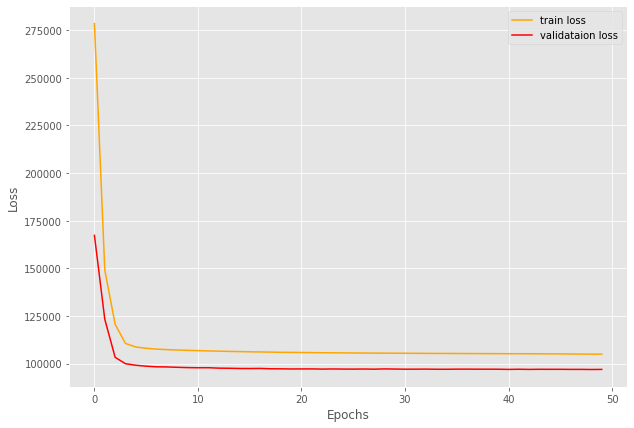

TRAINING COMPLETE


In [ ]:
train_loss = []
valid_loss = []
batch_size = 64
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")

    train_epoch_loss = train(
        model, trainloader, SAR_train, device, optimizer, criterion
    )
    valid_epoch_loss, recon_images = validate(
        model, testloader, SAR_validate, device, criterion
    )

    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)

    # save the reconstructed images from the validation loop
    save_reconstructed_images(recon_images, epoch+1)

    # convert the reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)

    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

# save the reconstructions as a .gif file
image_to_vid(grid_images)

# save the loss plots to disk
save_loss_plot(train_loss, valid_loss)
print('TRAINING COMPLETE')

In [ ]:
# from google.colab.patches import cv2_imshow
# import cv2

# epoch1 = cv2.imread('output1.jpg')
# cv2_imshow(epoch1)

# epoch50 = cv2.imread('output50.jpg')
# cv2_imshow(epoch50)

In [ ]:
#Save model
torch.save(model.state_dict(), 'SAR10_cvae.pt')

CVAE_data = data

#Encode the dataset and save to npz file
with torch.no_grad():
    mu = model.encode(CVAE_data.to(device))
    Y = mu.cpu().numpy()
    np.savez_compressed('SAR10_cvae.npz',data=Y,labels=labels)

#Active Learning on CNN-VAE Output

In [ ]:
M = np.load('SAR10_cvae.npz')
X = M['data']   #Encoded data
labels = M['labels'] #Labels

print(X.shape)
print(labels.shape)
print(X)
print(labels)

(6874, 7744)
(6874,)
[[0.00411705 0.00648508 0.00552337 ... 0.         0.         0.        ]
 [0.00271531 0.00806503 0.01036347 ... 0.         0.         0.        ]
 [0.00104573 0.00385273 0.00455239 ... 0.         0.         0.        ]
 ...
 [0.00044986 0.00802044 0.01214229 ... 0.         0.         0.        ]
 [0.00103577 0.00691095 0.00963898 ... 0.         0.         0.        ]
 [0.00192104 0.00692684 0.00804433 ... 0.         0.         0.        ]]
[0 0 0 ... 3 3 3]


In [ ]:
#2. CVAE Output
W = weight_matrix(X)
_, mc_vopt_laplace, mc_vopt_poisson = mc_vopt_simulation(W, labels, 20, 300, 7)
_, vopt_laplace, vopt_poisson = vopt_simulation(W, labels, 20, 300, 7)
num_train, random_laplace, random_poisson = random_simulation(W, labels, 20, 300, 7)
_, unc_laplace, unc_poisson = uncertainty_simulation(W, labels, 20, 300, 7)
_, sopt_laplace, sopt_poisson = sigmaopt_simulation(W, labels, 20, 300, 7)

MC-VOptimality
2.909514% training data
Number of Labels,Accuracy
Laplace: 200,86.980
Poisson: 200,86.980
negative diagonals: 0
negative entries: 21937686
2.853700341177223 22.538982212960644
Number of Labels,Accuracy
Laplace: 201,86.975
Poisson: 201,86.975
2.8535412407902156 22.117921826315587
Number of Labels,Accuracy
Laplace: 202,87.004
Poisson: 202,87.004
2.856606511524508 18.23023951111629
Number of Labels,Accuracy
Laplace: 203,87.033
Poisson: 203,87.033
2.8059101974386262 17.342994103101766
Number of Labels,Accuracy
Laplace: 204,88.429
Poisson: 204,88.429
2.8060363181299044 17.182347243095734
Number of Labels,Accuracy
Laplace: 205,88.426
Poisson: 205,88.426
2.805005249649535 16.555226153211095
Number of Labels,Accuracy
Laplace: 206,89.256
Poisson: 206,89.256
2.8043158348469985 15.601631285218343
Number of Labels,Accuracy
Laplace: 207,89.286
Poisson: 207,89.286
2.804478183872361 14.96839789558583
Number of Labels,Accuracy
Laplace: 208,89.516
Poisson: 208,89.516
2.7989505184081835 1

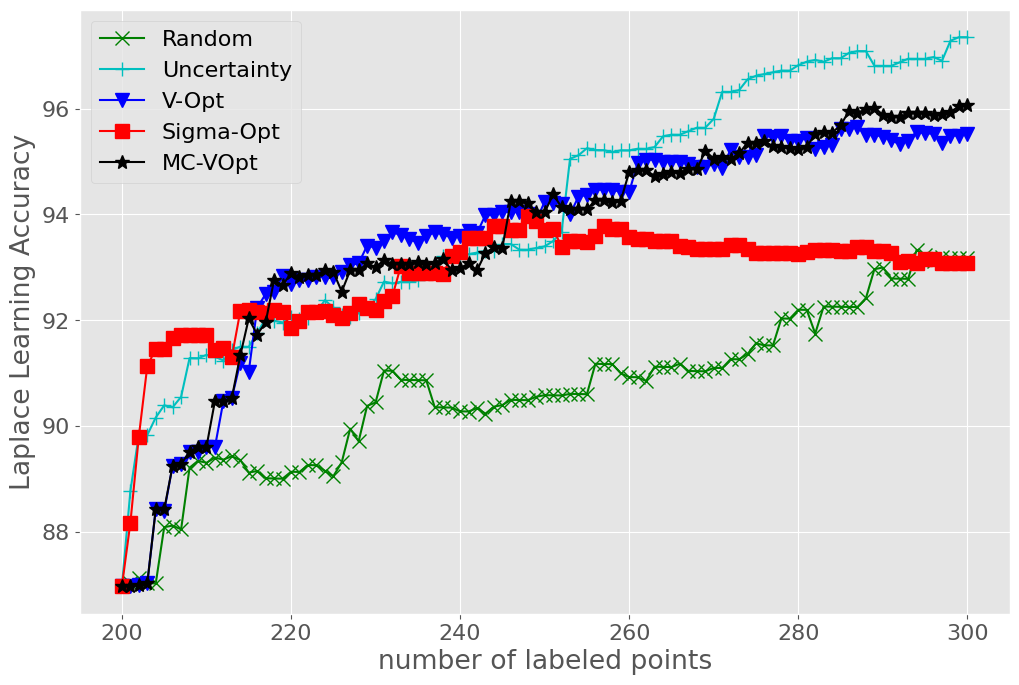

rand: 93.331 unc: 97.348 vopt: 95.645 sopt: 93.976 mc: 300.000 mc-vopt: 96.073


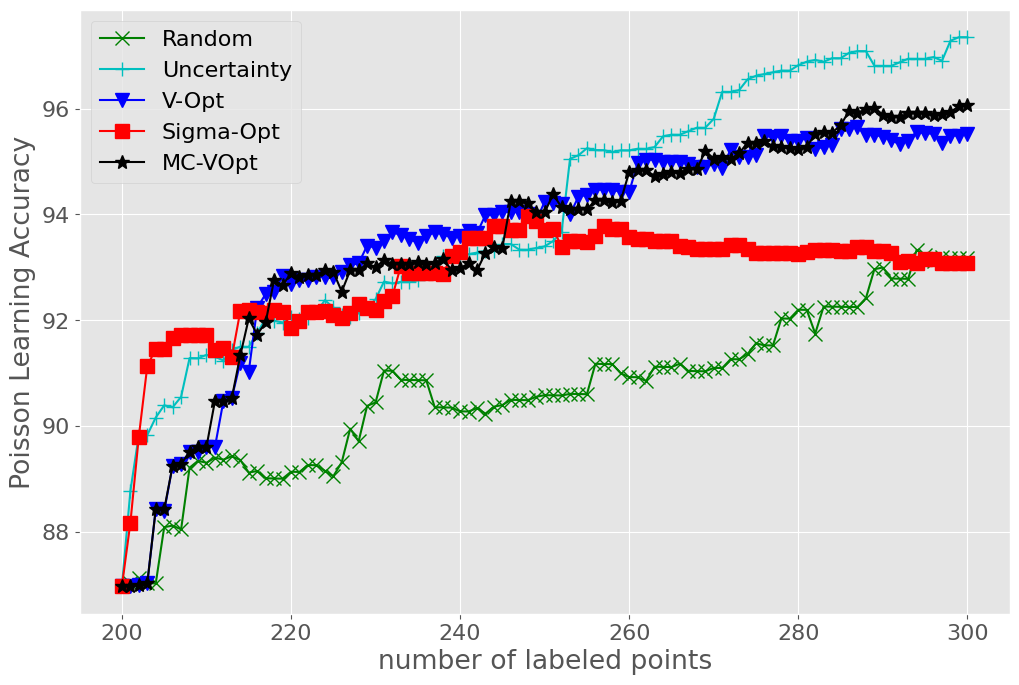

rand: 93.331 unc: 97.348 vopt: 95.645 sopt: 93.976 mc: 300.000 mc-vopt: 96.073


In [ ]:
lineplot(num_train, random_laplace, unc_laplace, vopt_laplace, sopt_laplace, _, mc_vopt_laplace, 'Laplace', filename='CVAE_Laplace')
lineplot(num_train, random_poisson, unc_poisson, vopt_poisson, sopt_poisson, _, mc_vopt_poisson, 'Poisson', filename='CVAE_Poisson')